![title](Beach.jpg)

# Business Understanding
Ask relevant questions and define objectives for the problem that needs to be tackled
## Key Question
We are tasked by a consortium of investors to evaluate favourable real estate investing opportunities in the Seattle area. 
* **Based on the King County dataset, what are some of the most attractive real estate options currently available?** (at a price that lies below the predicted value and, ideally, has upward potential)

## Glossary
* **id** - unique ID for each home sold
* **date** - date of the home sale
* **price** - price for each home sold (prediction target!)
* **bedrooms** - # of Bedrooms/House
* **bathrooms** - # of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** - square footage of the land space
* **floors** - # of floors (levels) in house
* **waterfront** - dummy for whether house is overlooking the waterfront or not
* **view** - has been viewed OR index from 0 to 4 of how good the view of the property was (inconclusive)
* **condition** - index from 1 to 5 of how good the condition is (overall)
* **grade** - index from 1 to 13 based on King County grading system (1-6: below avg construction and design; 11-13: high quality level construction and design)
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - year the house was initially built
* **yr_renovated** - year when house was last renovated
* **zipcode** - zipcode area the house is in
* **lat** - latitude coordinate
* **long** - longitude coordinate
* **sqft_living15** - square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - square footage of the land lots of the nearest 15 neighbors

## Variable Description
* **data_raw** - Originally imported dataset
* **data** - Main working dataset containing cleaned and refined data
* **data_clean** - Copy of data after 3 Data Cleaning used during 4 Data Exploration
* **data_results** - Main working dataset incl. predicted values and residuals from selected regression model
* **data_results_1..** - Interim results of the regression models

## Open Topics
- Correlation matrix/heatmap
- Split into test and training sets
- Optimize Root Mean Squared Error (RMSE)
- Define AT LEAST 3 recommendations for home buyers in King County
- Write README.md file
- Change color palette to fit Google Slides
- Build meaningful visualizations
- Finalize Presentation

## Recommendations
- These houses (1-10)
- Optimal months to buy houses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import scipy as sc
from scipy.stats import kstest
from scipy.stats import zscore
import seaborn as sns
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

sns.set(style="white")
%matplotlib inline

#Subplots
from plotly.subplots import make_subplots
from numpy import median

# Data Mining
Gather and scrape the data necessary for the project

In [2]:
data_raw = pd.read_csv("King_County_House_prices_dataset.csv")
data = data_raw

In [3]:
data.shape

(21597, 21)

In [4]:
# data.columns

In [5]:
# data.head()

# Data Cleaning
Fix the inconsistencies within the data and handle the missing values

## Inspection
- Describe (Summary)
- Datatypes
- Correlation
- Missing values

In [6]:
# Describe (Summary)
#data.describe().T

In [7]:
# Datatypes (data.info())
# data.info()

In [8]:
# Correlation
#data.corr().head()

In [9]:
# Missing values

#print(data.isnull().sum())

def count_missing(data):
    null_cols = data.columns[data.isnull().any(axis=0)]
    X_null = data[null_cols].isnull().sum()
    X_null = X_null.sort_values(ascending=False)
    print(X_null)
    
#count_missing(data)

## Data Handling
- date
- sqft_basement
- waterfront
- view
- outliers:
  - bedrooms
  - sqft_living
  - sqft_lot

In [10]:
# date: split into date_month and date_year, and make date a continuum from min to max - OPTIMIZE
data["date_month"] = [int(el.split("/")[0]) for el in data.date.values.tolist()]
data["date_year"] = [int(el.split("/")[2]) for el in data.date.values.tolist()]
data.date_old = data.date
data.date = data.date_month + (data.date_year-2014)*12

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [11]:
# sqft_basement: set to sqft_living - sqft_above
data.sqft_basement = data.sqft_living - data.sqft_above

In [12]:
# waterfront: Assume NaN=0
data.waterfront.fillna(0.0, inplace=True)

In [13]:
# view: Assume NaN=0 - OPTIMIZE (check whether 0 is a good assumption)
data.view.fillna(0.0, inplace=True)

In [14]:
# outliers: bedrooms (33 beds) - OPTIMIZE (how to remove outliers in a more systematic manner?)
data.drop(data.loc[data.bedrooms==data.bedrooms.max()].index.tolist(), axis=0, inplace=True)

In [15]:
# outliers: sqft_living (2)
data.drop(data.loc[data.sqft_living==data.sqft_living.max()].index.tolist(), axis=0, inplace=True)
#data.drop(data.loc[data.sqft_living==data.sqft_living.max()].index.tolist(), axis=0, inplace=True)

In [16]:
# outliers: sqft_lot
data.drop(data.loc[data.sqft_lot==data.sqft_lot.max()].index.tolist(), axis=0, inplace=True)

# Data Exploration
Form hypotheses about your defined problem by visually analyzing the data

In [17]:
# Clean data set for exploration
data_clean = data

In [18]:
# separate continuous vs. categorical variables
data_cat_col = ['condition', 'date', 'date_month', 'date_year', 'grade','zipcode', 'view']
data_cont_col = [el for el in data_clean.columns if el not in data_cat_col]
data_cont = data_clean[data_cont_col]
data_cat = data_clean[data_cat_col]

In [19]:
# Describe price variable (histogram, info)

In [20]:
# Look at data skew
data.skew()

id                0.243009
date              0.192757
price             4.025260
bedrooms          0.549635
bathrooms         0.501988
sqft_living       1.399850
sqft_lot         11.463756
floors            0.614056
waterfront       12.038731
view              3.407738
condition         1.036162
grade             0.787088
sqft_above        1.420774
sqft_basement     1.556005
yr_built         -0.469562
yr_renovated      4.572945
zipcode           0.405245
lat              -0.485259
long              0.885156
sqft_living15     1.105461
sqft_lot15        9.535126
date_month        0.063242
date_year         0.757268
dtype: float64

In [21]:
# Correlation heatmap continuous
# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(data_cont.corr(), dtype=np.bool))

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(data_cont.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

In [22]:
# Plot all variables as pairplot
#sns.pairplot(data_clean);

In [23]:
# Plot selection of variables as pairplot
#sns.pairplot(data_clean, kind="reg", vars=["price", "bedrooms", "bathrooms", "sqft_lot"], 
#             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}});

In [24]:
# Plot FacetGrid
#g = sns.FacetGrid(data,
#                  col='view',
#                  row='bedrooms',
#                  hue='waterfront',
#                  palette='Set2')
#g = (g.map(plt.scatter, 'sqft_living', 'log_price').add_legend())

In [25]:
# Plot continuous variables
#plt.hist(data_clean.price, bins = 25);
#plt.hist(np.log(data_clean.price), bins = 25);
#plt.tight_layout()

In [26]:
# Plot categorical variables
#sns.stripplot(x=data_clean.condition.values, y = data_clean.price.values, 
#              jitter=0.1, alpha=0.5);

#sns.stripplot(x=data_clean.grade.values, y = data_clean.price.values,
#              jitter=0.1, alpha=0.5);

#sns.stripplot(x=data_clean.zipcode.values, y = data_clean.price.values,
#              jitter=0.1, alpha=0.5);

#sns.pointplot(x = data_clean.zipcode.values, y = data_clean.price.values,
#              order = data_clean.groupby("zipcode")["price"].mean().sort_values().index);

#plt.tight_layout()

# Feature Engineering
Select important features and construct more meaningful ones using the raw data that you have

- renovated
- price_log
- yr_since_built
- yr_renovated
- yr_since_last_renovated
- categorical --> dummies
  - condition
  - grade
  - zipcode
- drop:
  - id
  - date
  - condition
  - grade
  - zipcode
  - sqft_living

In [27]:
# renovated: Add 1/0 variable for whether house has been renovated, assuming 0 for NaN-Values
data["renovated"] = data["yr_renovated"] > 0
data.renovated.replace([True, False], [1, 0], inplace=True)

In [28]:
# price_log: column with log of price
# data.head()
data["price_log"] = [math.log(el) for el in data["price"]]
# data.price_log.hist();

In [29]:
# yr_since_built: column with years between yr_built and sold
data["yr_since_built"] = data.date_year - data.yr_built

In [30]:
# yr_renovated: fill column to represent the max from yr_renovated and yr_built
#data["yr_renovated"] = [max(data.yr_built[i],data.yr_renovated[i]) for i in data.yr_built]
data["yr_renovated"] = data[["yr_built","yr_renovated"]].max(axis=1)

In [31]:
# yr_since_last_renovated: column with years between yr_built or yr_renovated and sold
data["yr_since_last_renovated"] = data.date_year - data.yr_renovated

In [32]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'date_month', 'date_year',
       'renovated', 'price_log', 'yr_since_built', 'yr_since_last_renovated'],
      dtype='object')

In [33]:
# categorical --> dummies - OPTIMIZE
cat = data.filter(["condition", 
                   "grade", 
                   "zipcode", "view"], axis=1).astype("category")
data_dum = pd.DataFrame()
data_dum_i = pd.DataFrame()
for i in cat:
    data_dum_i = pd.get_dummies(cat[i], prefix=i, drop_first=True)
    data_dum = pd.concat([data_dum, data_dum_i], axis=1)
data_without_dum = data
data = pd.concat([data, data_dum], axis=1)
data.reset_index(drop = True, inplace = True)

# data_dum = pd.get_dummies(data, columns=["condition", "grade", "zipcode"], prefix=["condition", "grade","zipcode"])
# data_wo_dum = data
# data_new = pd.concat([data, data_dum], axis=1)

In [34]:
# drop: id, condition, grade, zipcode, view, sqft_living
data = data.drop(["id", "condition", "grade", "zipcode", "view", "sqft_living"], axis=1)

In [35]:
# Normalize variables
#Create new df
data_norm = data.copy(deep=True)
#drop columns
data_norm.drop(['yr_built', 'yr_renovated', 'yr_since_built'],
               axis=1,
               inplace=True)
#z normalize variables
data_norm.loc[:, [
    'date', 'bedrooms', 'bathrooms', 'waterfront', 'price_log', 'sqft_lot',
    'sqft_above', 'sqft_basement', 'floors', 'lat', 'long', 'sqft_living15',
    'sqft_lot15', 'yr_since_last_renovated'
]] = data.loc[:, [
    'date', 'bedrooms', 'bathrooms', 'waterfront', 'price_log', 'sqft_lot',
    'sqft_above', 'sqft_basement', 'floors', 'lat', 'long', 'sqft_living15',
    'sqft_lot15', 'yr_since_last_renovated'
]].apply(zscore)
#add intercept column
#data_norm['intercept'] = 1
print(data_norm.shape)
data_norm.head()

(21594, 105)


,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,sqft_above,sqft_basement,lat,...,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,view_1.0,view_2.0,view_3.0,view_4.0
0,-0.120896,221900.0,-0.411193,-1.452756,-0.234954,-0.915645,-0.082506,-0.736309,-0.659747,-0.352959,...,0,0,1,0,0,0,0,0,0,0
1,0.416712,538000.0,-0.411193,0.174986,-0.194994,0.937616,-0.082506,0.462022,0.245419,1.161455,...,0,0,0,0,0,0,0,0,0,0
2,0.954320,180000.0,-1.517648,-1.452756,-0.125767,-0.915645,-0.082506,-1.232587,-0.659747,1.283445,...,0,0,0,0,0,0,0,0,0,0
3,0.416712,604000.0,0.695262,1.151631,-0.251270,-0.915645,-0.082506,-0.893666,1.399505,-0.283663,...,0,0,0,0,0,0,0,0,0,0
4,0.954320,510000.0,-0.411193,-0.150563,-0.173960,-0.915645,-0.082506,-0.131092,-0.659747,0.409301,...,0,0,0,0,0,0,0,0,0,0


# Predictive Modeling
Train machine learning models, evaluate their performance and use them to make predictions

In [36]:
#1.1 OLS with y=price_log and all parameters (0.881)
#X = data.drop(["price", "price_log"], axis=1)
#X = sm.add_constant(X)
#y = data.price_log
#data_results_1_1 = sm.OLS(y,X).fit()
#data_results_1_1.summary()

In [37]:
#1.2 Lasso with X, y values from #1.1 (0.51) 
#from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
#import matplotlib

#lasso = LassoCV()
#lasso.fit(X, y)
#print("Best alpha using built-in LassoCV: %f" % lasso.alpha_)
#print("Best score using built-in LassoCV: %f" %lasso.score(X,y))
#coef = pd.Series(lasso.coef_, index = X.columns)

#print("Lasso picked " 
#      + str(sum(coef != 0)) 
#      + " variables and eliminated the other " 
#      +  str(sum(coef == 0)) + " variables")

#imp_coef = coef.sort_values()
#matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
#imp_coef.plot(kind = "barh")
#plt.title("Feature importance using Lasso Model")

In [38]:
#1.3 OLS with normalized values (0.881)
#Xb = data_norm.drop(["price","price_log"], axis=1)
#Xb = sm.add_constant(Xb)
#yb = data_norm.price_log
#data_results_1_3 = sm.OLS(yb,Xb).fit()
#data_results_1_3.summary()

In [39]:
#2 OLS with y=price_log and all but selected variables (0.879)
X2 = data.drop(["price", "price_log", "renovated", "yr_since_last_renovated", 
               "yr_renovated", "yr_built", "lat", "long", "sqft_lot"], axis=1)
X2 = sm.add_constant(X2)
y2 = data.price_log
data_results_2 = sm.OLS(y2,X2).fit()
data_results_2.summary()

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1607.
Date:                Tue, 09 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:37:22   Log-Likelihood:                 6096.7
No. Observations:               21594   AIC:                        -1.200e+04
Df Residuals:                   21495   BIC:                        -1.121e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.581e-06   5.06e-08     51.036      0.000    2.48e-06    2.68e-06
date               0.0051      0.000     14.249      0.000       0.004       0.006
bedrooms          -0.0052      0.002     -2.767      0.006      -0.009      -0.002
bathrooms          0.0448      0.003     14.968      0.000       0.039       0.051
floors            -0.0345      0.004     -9.474      0.000      -0.042      -0.027
waterfront         0.4307      0.019     22.808      0.000       0.394       0.468
sqft_above         0.0002    3.6e-06     60.380      0.000       0.000       0.000
sqft_basement      0.0001   4.09e-06     32.833      0.000       0.000       0.000
sqft_living15   7.834e-05   3.31e-06     23.668      0.000    7.19e-05    8.48e-05
sqft_lot15      6.848e-07   5.26e-08     13.027      0.000    5.82e-07    7.88e-07
date_month        -0.0021      0.000     -5.037      0.000      -0.003      -0.001
date_year          0.0058   9.29e-05     62.468      0.000       0.006       0.006
yr_since_built     0.0010   7.13e-05     13.477      0.000       0.001       0.001
condition_2        0.1291      0.037      3.493      0.000       0.057       0.202
condition_3        0.2590      0.034      7.533      0.000       0.192       0.326
condition_4        0.3002      0.034      8.725      0.000       0.233       0.368
condition_5        0.3630      0.035     10.489      0.000       0.295       0.431
grade_4           -0.4423      0.187     -2.369      0.018      -0.808      -0.076
grade_5           -0.3906      0.184     -2.126      0.034      -0.751      -0.030
grade_6           -0.2714      0.183     -1.480      0.139      -0.631       0.088
grade_7           -0.1443      0.183     -0.787      0.431      -0.504       0.215
grade_8           -0.0415      0.183     -0.226      0.821      -0.401       0.318
grade_9            0.0606      0.184      0.330      0.741      -0.299       0.420
grade_10           0.1106      0.184      0.602      0.547      -0.249       0.471
grade_11           0.1308      0.184      0.711      0.477      -0.230       0.491
grade_12           0.1418      0.185      0.767      0.443      -0.221       0.504
grade_13           0.1228      0.191      0.642      0.521      -0.252       0.498
zipcode_98002     -0.0294      0.016     -1.810      0.070      -0.061       0.002
zipcode_98003     -0.0001      0.015     -0.009      0.993      -0.029       0.028
zipcode_98004      1.0842      0.014     75.753      0.000       1.056       1.112
zipcode_98005      0.7095      0.017     41.042      0.000       0.676       0.743
zipcode_98006      0.6106      0.013     47.185      0.000       0.585       0.636
zipcode_98007      0.6322      0.018     34.646      0.000       0.596       0.668
zipcode_98008      0.6258      0.015     42.832      0.000       0.597       0.654
zipcode_9801

In [40]:
#3 OLS with y=price and without dummies (0.716)
#X3 = data[['bedrooms', 'bathrooms', 'sqft_lot', 'floors',
#       'waterfront', 'sqft_above',
#       'sqft_basement', 'lat', 'long', 'sqft_living15',
#       'sqft_lot15', 'renovated', "yr_since_last_renovated"]]
#X3 = sm.add_constant(X3)
#y3 = data.price_log
#data_results_3 = sm.OLS(y3,X3).fit()
#data_results_3.summary()

RMSE: 0.18219838395205085
0.8800448101795749


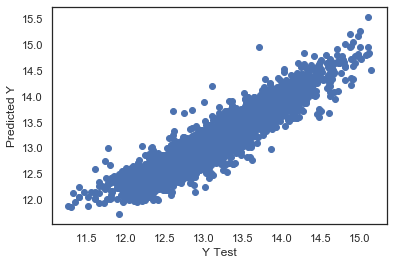

In [41]:
#4 Advanced model using price_log (0.88)
y4 = data['price_log']
X4 = data.drop(["price", "price_log", "renovated", "yr_since_last_renovated", 
               "yr_renovated", "yr_built", "lat", "long", "sqft_lot"], axis=1)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,
                                                        y4,
                                                        test_size=0.33,
                                                        random_state=42,
                                                        shuffle=False)

lm = LinearRegression()
lm.fit(X4_train, y4_train)
#print('Coefficients: \n', lm.coef_)

predictions = lm.predict(X4_test)
plt.scatter(y4_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

#print('MAE:', metrics.mean_absolute_error(y4_test, predictions))
#print('MSE:', metrics.mean_squared_error(y4_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y4_test, predictions)))
print(r2_score(y4_test, predictions))

In [42]:
# Histogram for test predictions
#sns.distplot((y4_test-predictions),bins=50);
#plt.tight_layout()

In [47]:
# Data_results DataFrame to identify top 5 high-end and top 5 lower-grade real estate
data_results = data[['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above',
       'sqft_basement', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'renovated', "yr_since_last_renovated", "grade_4", "grade_5", "grade_6"]]
data_results['y_hat_log'] = data_results_2.fittedvalues
data_results['res_log'] = data_results_2.resid
data_results['y_hat'] = [math.exp(el) for el in data_results['y_hat_log']]
data_results['res'] = data_results['price'] - data_results['y_hat']
data_results['res_rel'] = data_results['res'] / data_results['y_hat']

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,sqft_above,sqft_basement,lat,long,...,renovated,yr_since_last_renovated,grade_4,grade_5,grade_6,y_hat_log,res_log,y_hat,res,res_rel
0,221900.0,3,1.00,5650,1.0,0.0,1180,0,47.5112,-122.257,...,0,59.0,0,0,0,12.376724,-0.066742,237215.377112,-15315.377112,-0.064563
1,538000.0,3,2.25,7242,2.0,0.0,2170,400,47.7210,-122.319,...,1,23.0,0,0,0,13.121398,0.074216,499517.380870,38482.619130,0.077040
2,180000.0,2,1.00,10000,1.0,0.0,770,0,47.7379,-122.233,...,0,82.0,0,0,1,12.614438,-0.513726,300871.240014,-120871.240014,-0.401737
3,604000.0,4,3.00,5000,1.0,0.0,1050,910,47.5208,-122.393,...,0,49.0,0,0,0,13.172686,0.138644,525805.103232,78194.896768,0.148715
4,510000.0,3,2.00,8080,1.0,0.0,1680,0,47.6168,-122.045,...,0,28.0,0,0,0,13.089123,0.053043,483652.903840,26347.096160,0.054475


In [48]:
data_results.sort_values("res_rel").head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,sqft_above,sqft_basement,lat,long,...,renovated,yr_since_last_renovated,grade_4,grade_5,grade_6,y_hat_log,res_log,y_hat,res,res_rel
1624,169317.0,2,1.0,4000,1.0,0.0,790,0,47.6248,-122.301,...,0,107.0,0,0,0,13.386976,-1.347448,6.514633e+05,-4.821463e+05,-0.740097
1220,130000.0,3,1.0,7520,1.0,0.0,1110,0,47.6830,-122.176,...,0,55.0,0,0,0,13.088523,-1.313233,4.833627e+05,-3.533627e+05,-0.731051
12538,90000.0,2,1.0,2640,1.0,0.0,790,0,47.7351,-122.178,...,0,41.0,0,0,0,12.657828,-1.250263,3.142135e+05,-2.242135e+05,-0.713571
21031,900000.0,5,6.0,40806,2.0,0.0,5480,1640,47.5451,-122.114,...,0,8.0,0,0,0,14.958411,-1.248261,3.135849e+06,-2.235849e+06,-0.712996
18315,130000.0,3,1.0,7000,2.0,0.0,1200,0,47.5883,-122.384,...,0,106.0,0,0,0,12.878113,-1.102823,3.916458e+05,-2.616458e+05,-0.668067
21353,490000.0,5,3.5,2975,3.0,0.0,3280,1180,47.6313,-122.370,...,0,-1.0,0,0,0,14.204256,-1.102096,1.475130e+06,-9.851296e+05,-0.667826
14819,300523.0,3,2.5,6840,2.0,0.0,2370,0,47.6503,-122.366,...,0,28.0,0,0,0,13.707596,-1.094316,8.977043e+05,-5.971813e+05,-0.665232
12808,145000.0,2,1.0,8125,1.0,0.0,800,0,47.6836,-122.174,...,0,50.0,0,0,1,12.887045,-1.002555,3.951594e+05,-2.501594e+05,-0.633059
3839,216650.0,3,3.5,1427,2.0,0.0,1360,180,47.5420,-122.322,...,0,7.0,0,0,0,13.277002,-0.990964,5.836181e+05,-3.669681e+05,-0.628781
8266,82000.0,3,1.0,10426,1.0,0.0,860,0,47.4987,-122.341,...,0,60.0,0,0,1,12.304963,-0.990489,2.207891e+05,-1.387891e+05,-0.628605


In [50]:
# Real estate with grades 4-6 (sub-par)
data_results["grade"] = data_results["grade_4"] + data_results["grade_5"] + data_results["grade_6"]
data_results[data_results["grade"] == 1].sort_values("res_rel").head()
#data_results.query("(data_results.grade_4 == 1) OR (data_results.grade_5 == 1) OR (data_results.grade_6 == 1)").sort_values("res_rel").head(10)

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,sqft_above,sqft_basement,lat,long,...,yr_since_last_renovated,grade_4,grade_5,grade_6,y_hat_log,res_log,y_hat,res,res_rel,grade
12808,145000.0,2,1.0,8125,1.0,0.0,800,0,47.6836,-122.174,...,50.0,0,0,1,12.887045,-1.002555,395159.397949,-250159.397949,-0.633059,1
8266,82000.0,3,1.0,10426,1.0,0.0,860,0,47.4987,-122.341,...,60.0,0,0,1,12.304963,-0.990489,220789.137381,-138789.137381,-0.628605,1
17180,110000.0,3,1.0,53143,1.0,0.0,1250,0,47.4235,-122.051,...,69.0,0,0,1,12.579972,-0.971736,290678.127900,-180678.127900,-0.621575,1
7984,90000.0,1,1.0,4000,1.0,0.0,780,0,47.5424,-122.321,...,110.0,0,1,0,12.341447,-0.933882,228992.956241,-138992.956241,-0.606975,1
16876,125000.0,3,1.0,4800,1.5,0.0,1230,0,47.6941,-122.365,...,98.0,0,0,1,12.666678,-0.930609,317006.527965,-192006.527965,-0.605686,1
15794,133000.0,5,2.0,5600,1.5,0.0,1430,0,47.5192,-122.266,...,67.0,0,0,1,12.677064,-0.878960,320316.276980,-187316.276980,-0.584785,1
13398,122000.0,2,1.0,6840,1.0,0.0,740,0,47.5168,-122.373,...,73.0,0,0,1,12.562720,-0.850943,285706.318139,-163706.318139,-0.572988,1
3762,84000.0,2,1.0,20130,1.0,0.0,700,0,47.4752,-122.271,...,66.0,0,0,1,12.167830,-0.829258,192495.815678,-108495.815678,-0.563627,1
8197,107000.0,2,1.0,4720,1.0,0.0,670,0,47.5243,-122.358,...,66.0,0,0,1,12.385227,-0.804643,239241.055471,-132241.055471,-0.552752,1
12364,107000.0,3,1.5,5120,1.0,0.0,910,0,47.5238,-122.356,...,41.0,0,0,1,12.384239,-0.803655,239004.768456,-132004.768456,-0.552310,1


# Data Visualization
Communicate the findings with key stakeholders using plots and interactive visualizations

In [ ]:
data[["price","price_log"]].head()